In [1]:
from typing import Union
import pdb
import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import jax.tree_util as jtu
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax
import numpy as np
import control
import pdb
import jax
import lineax
from helpers_impl import generate_system,  NeuralODEPlant, get_gpu_memory, generate_system_canon, generate_system_canon2
from tqdm import tqdm
import gc
from IPython.display import clear_output
gc.collect()  
print(get_gpu_memory())
jax.config.update("jax_enable_x64", False)

[{'device': 0, 'total_memory': 24564.0, 'free_memory': 5127.125, 'used_memory': 19436.875}]


In [77]:
saved_global_loss=[]
saved_global_kin=[]
saved_global_emaloss=[]
saved_global_emakin=[]
saved_global_orparam=[]
saved_glocal_stdloss=[]
saved_global_stdkin=[]
save_A=[]
save_B=[]
save_x00=[]
for data_size in range(1,6):


    
    A,B=generate_system_canon2(data_size,data_size)
    
    batch_size=16
    
    
    scaling=1
    
    seed=5679
    key = jr.PRNGKey(seed)
    x00=np.array(jr.normal(key, shape=(1, data_size)))
    x00=x00/np.sqrt(np.sum(x00**2))
    
    %store  A
    %store   B
    %store  x00
    print(A)
    print(B)
    print(x00)
    
    save_A.append(A)
    save_B.append(B)
    save_x00.append(x00)
    t_size=32
    
        
    t0 = 0
    t1 = 1
    ts = jnp.linspace(t0, t1, t_size)
    
    seed=5679
    
    hidden_size=data_size
    noise_size=hidden_size+1
    width_size=5*data_size
    depth=5
    
    key = jr.PRNGKey(seed)
    
    
    t_size=32
    
      
    t0 = 0
    t1 = 1
    ts = jnp.linspace(t0, t1, t_size)
    
    tss = jnp.expand_dims(ts, axis=0)
    tsss = jnp.repeat(tss, repeats=batch_size, axis=0)
    
    learning_rate=0.0001
    
    R=0.00
    saved_scores=[]
    
    
    
    @eqx.filter_vmap
    def make_ensemble(key):
        return NeuralODEPlant(
            data_size,
            hidden_size,
            width_size,
            depth,
            A,
            B,
            key=key,
            )
        
    seed=5679
    
    key = jr.PRNGKey(seed)
    
    #keys = jax.random.split(key, batch_size)
    keys = jnp.repeat(jnp.expand_dims(key,0),batch_size
                      ,axis=0)
    mlp_ensemble = make_ensemble(keys)
    hidden_size
    
    y0=jnp.append(x00, jnp.zeros((1,1)))
    
    
    mu=(A,B)
    def loss2(model):
    
        pred = model( ts, y0, mu)
        
    
        #kin_energy=  jnp.mean(pred[:,-1,-1])
        score=jnp.sum(pred[-1,0:hidden_size]**2)
        #ord_param=jnp.mean(order_param(pred[:,-1,0:hidden_size],L))
        #los_energy = jnp.mean(jnp.sum(pred_y[:,-1,0:hidden_size]**2,axis=1))
      
        return score
    
    @eqx.filter_vmap
    def prediction(model):
        
          
        pred_y = model( ts, y0, mu)    
         
       
        return pred_y
    
    
    @eqx.filter_vmap
    def evaluate_per_ensemble(model):
        
          
        values, grads = eqx.filter_value_and_grad(loss2)(model)     
         
       
        return values, grads
    
    @eqx.filter_vmap
    def evaluate_per_ensemble_optims(model,updates):
        
          
        model =eqx.apply_updates(model, updates)   
         
       
        return model
    
    b1=0.9
    b2=0.999
    eps=1e-08
    optim = optax.adam(learning_rate, b1=b1, b2=b2, eps=0, eps_root=eps)
    #opt_state = optim.init(eqx.filter(mlp_ensemble, eqx.is_inexact_array))
    opt_states = jax.vmap(optim.init)(eqx.filter(mlp_ensemble, eqx.is_inexact_array))
    
    
    
    @eqx.filter_jit
    def make_step(models, batch_size,  key, opt_states,optim):
    
    
        values, grads =evaluate_per_ensemble(models)
        
        pred_y =prediction(models)
    
        loss=jnp.mean(values) 
        std_loss=jnp.std(values)
        kin_energy=  jnp.mean(pred_y[:,-1,-1])
        std_kin= jnp.std(pred_y[:,-1,-1])
       
        updates, opt_states = jax.vmap(optim.update)(grads, opt_states)
        models= evaluate_per_ensemble_optims(models, updates)
    
    
        
        jax.debug.print("🤯training value: {value} 🤯", value=loss)
        jax.debug.print("🤯training kin_energy: {kin_energy} 🤯", kin_energy=kin_energy)
        jax.debug.print("training std value: {std}", std=std_loss)
        jax.debug.print("training std kin: {std}", std=std_kin)
    
        
       
        return models, opt_states, grads, loss, kin_energy, std_loss, std_kin
    
    # And now let's train for a short while -- in exactly the usual way -- and see what
    
    
    
    for glob in tqdm(range(0,20)):
        seed=5679
    
        key = jr.PRNGKey(seed)
        
        keys = jax.random.split(key, batch_size)
        #keys = jnp.repeat(jnp.expand_dims(key,0),batch_size
        #                  ,axis=0)
        mlp_ensemble = make_ensemble(keys)
    
        
        tot_iter=50000
    
        learning_rate=0.00003*(2**(glob/2))
        #learning_rate= 0.0001
        #adam optimizer
        b1=0.9
        b2=0.999
        eps=1e-08
        optim = optax.adam(learning_rate, b1=b1, b2=b2, eps=0, eps_root=eps)
        #opt_state = optim.init(eqx.filter(mlp_ensemble, eqx.is_inexact_array))
        opt_states = jax.vmap(optim.init)(eqx.filter(mlp_ensemble, eqx.is_inexact_array))
        
    
        alpha=0.995
        
        counter=jnp.int32(0)
        
        
        score=10000000
        epochs=[]
        ema_loss=0
        ema_kin=0
    
        saved_loss=[]
        saved_kin=[]
        #save directional derivatives
       
        saved_ema_loss=[]
        saved_ema_kin=[]
        saved_std_loss=[]
        saved_std_kin=[]
        for k in tqdm(range(0,tot_iter)):
    
            key= jr.split(key, 1)[0]
        
            
            mlp_ensemble, opt_states, grads, losses, kin, std_loss, std_kin = make_step(mlp_ensemble, batch_size,  key, opt_states,optim)
            
            if k==0:
                ema_loss=losses
                ema_kin = kin
            else:
                ema_loss=ema_loss*alpha+losses*(1-alpha)
                ema_kin=ema_kin*alpha+kin*(1-alpha)
                
            if ema_loss<score:
                score=ema_loss
        
            print("ema loss")
            print(ema_loss)
            print("kin")
            print(kin)
            print("order param")
      
            saved_loss.append(jax.device_get(losses))
            saved_kin.append(jax.device_get(kin))
            saved_ema_loss.append(jax.device_get(ema_loss))
            saved_ema_kin.append(jax.device_get(ema_kin))
            saved_std_loss.append(jax.device_get(std_loss))
            saved_std_kin.append(jax.device_get(std_kin))
        
            if k%500==0:
                gc.collect()
                clear_output(wait=True)
                
            if jnp.linalg.norm(ema_loss)<(1e-06):
                break
            del grads, losses, kin
            
        saved_global_loss.append(saved_loss)
        saved_global_kin.append(saved_kin)
        saved_global_emaloss.append(saved_ema_loss)
        saved_global_emakin.append(saved_ema_kin)
        saved_glocal_stdloss.append(saved_std_loss)
        saved_global_stdkin.append(saved_std_kin)
       


 99%|█████████▉| 49510/50000 [15:38<00:25, 19.52it/s]

🤯training value: 7.358235052379314e-06 🤯
🤯training kin_energy: 0.9727157950401306 🤯
training std value: 8.688300113135483e-06
training std kin: 0.001939510926604271
ema loss
7.821873e-06
kin
0.9727158
order param
🤯training value: 9.875390787783545e-06 🤯
🤯training kin_energy: 0.9728075265884399 🤯
training std value: 1.0750797628134023e-05
training std kin: 0.002323616063222289
ema loss
7.832141e-06
kin
0.9728075
order param
🤯training value: 1.0558565008977894e-05 🤯
🤯training kin_energy: 0.9720748662948608 🤯
training std value: 1.202743351313984e-05
training std kin: 0.0023307609371840954
ema loss
7.845772e-06
kin
0.97207487
order param
🤯training value: 8.44600799609907e-06 🤯
🤯training kin_energy: 0.9735344648361206 🤯
training std value: 9.213204975822009e-06
training std kin: 0.0021817563101649284
ema loss
7.848773e-06
kin
0.97353446
order param
🤯training value: 6.013724487274885e-06 🤯
🤯training kin_energy: 0.9727082848548889 🤯
training std value: 5.595569746219553e-06
training std kin:


 99%|█████████▉| 49524/50000 [15:38<00:15, 30.90it/s]

🤯training kin_energy: 0.9727818965911865 🤯
training std value: 8.052654266066384e-06
training std kin: 0.001582419965416193
ema loss
7.834891e-06
kin
0.9727819
order param
🤯training value: 5.457892257254571e-06 🤯
🤯training kin_energy: 0.9731278419494629 🤯
training std value: 8.185340448108036e-06
training std kin: 0.0016916642198339105
ema loss
7.823006e-06
kin
0.97312784
order param
🤯training value: 5.4157571867108345e-06 🤯
🤯training kin_energy: 0.9723242521286011 🤯
training std value: 5.087743375042919e-06
training std kin: 0.0018134342972189188
ema loss
7.81097e-06
kin
0.97232425
order param
🤯training value: 5.647591933666263e-06 🤯
🤯training kin_energy: 0.9725000858306885 🤯
training std value: 6.067869435355533e-06
training std kin: 0.0018901461735367775
ema loss
7.800153e-06
kin
0.9725001
order param
🤯training value: 7.3860892371158116e-06 🤯
🤯training kin_energy: 0.9727668762207031 🤯
training std value: 6.749393833160866e-06
training std kin: 0.0018721490632742643
ema loss
7.798082


 99%|█████████▉| 49537/50000 [15:38<00:11, 40.48it/s]

ema loss
7.736638e-06
kin
0.97181094
order param
🤯training value: 6.0260917962295935e-06 🤯
🤯training kin_energy: 0.973190426826477 🤯
training std value: 6.558374934684252e-06
training std kin: 0.0015328892040997744
ema loss
7.728085e-06
kin
0.9731904
order param
🤯training value: 7.969467333168723e-06 🤯
🤯training kin_energy: 0.9725193381309509 🤯
training std value: 4.944688498653704e-06
training std kin: 0.0020844722166657448
ema loss
7.729292e-06
kin
0.97251934
order param
🤯training value: 9.90016087598633e-06 🤯
🤯training kin_energy: 0.9727578163146973 🤯
training std value: 7.605326118209632e-06
training std kin: 0.0025220243260264397
ema loss
7.740146e-06
kin
0.9727578
order param
🤯training value: 1.0142536666535307e-05 🤯
🤯training kin_energy: 0.9730747938156128 🤯
training std value: 9.283012332161888e-06
training std kin: 0.0022923960350453854
ema loss
7.752158e-06
kin
0.9730748
order param
🤯training value: 7.745444236206822e-06 🤯
🤯training kin_energy: 0.9718455076217651 🤯
training s


 99%|█████████▉| 49543/50000 [15:39<00:10, 43.79it/s]

ema loss
7.689392e-06
kin
0.9726283
order param
🤯training value: 4.094914402230643e-06 🤯
🤯training kin_energy: 0.9728254675865173 🤯
training std value: 4.376021934149321e-06
training std kin: 0.0017751596169546247
ema loss
7.67142e-06
kin
0.97282547
order param
🤯training value: 5.4218935474636964e-06 🤯
🤯training kin_energy: 0.9726463556289673 🤯
training std value: 5.634896751871565e-06
training std kin: 0.0017716713482514024
ema loss
7.660172e-06
kin
0.97264636
order param
🤯training value: 6.549701083713444e-06 🤯
🤯training kin_energy: 0.9726598858833313 🤯
training std value: 7.932722837722395e-06
training std kin: 0.0017486935248598456
ema loss
7.654619e-06
kin
0.9726599
order param
🤯training value: 5.95814435655484e-06 🤯
🤯training kin_energy: 0.9725348949432373 🤯
training std value: 7.212775017251261e-06
training std kin: 0.001968461787328124
ema loss
7.646137e-06
kin
0.9725349
order param
🤯training value: 3.889979780069552e-06 🤯
🤯training kin_energy: 0.9728302359580994 🤯
training std


 99%|█████████▉| 49555/50000 [15:39<00:08, 49.45it/s]

🤯training value: 5.057049747847486e-06 🤯
🤯training kin_energy: 0.9726735949516296 🤯
training std value: 7.924356395960785e-06
training std kin: 0.0015978734008967876
ema loss
7.5386815e-06
kin
0.9726736
order param
🤯training value: 5.571931069425773e-06 🤯
🤯training kin_energy: 0.9728032350540161 🤯
training std value: 7.3494206844770815e-06
training std kin: 0.0017663397593423724
ema loss
7.5288476e-06
kin
0.97280324
order param
🤯training value: 5.771225914941169e-06 🤯
🤯training kin_energy: 0.9723267555236816 🤯
training std value: 5.2585687626560684e-06
training std kin: 0.0019428443629294634
ema loss
7.5200596e-06
kin
0.97232676
order param
🤯training value: 4.984542101738043e-06 🤯
🤯training kin_energy: 0.9725589156150818 🤯
training std value: 4.378151061246172e-06
training std kin: 0.0016189741436392069
ema loss
7.507382e-06
kin
0.9725589
order param
🤯training value: 3.3436381272622384e-06 🤯
🤯training kin_energy: 0.9730096459388733 🤯
training std value: 3.5667289921548218e-06
training 


 99%|█████████▉| 49568/50000 [15:39<00:08, 53.96it/s]

ema loss
7.417858e-06
kin
0.97221875
order param
🤯training value: 6.497024514828809e-06 🤯
🤯training kin_energy: 0.972804844379425 🤯
training std value: 1.066110962710809e-05
training std kin: 0.0018341491231694818
ema loss
7.413254e-06
kin
0.97280484
order param
🤯training value: 9.830300768953748e-06 🤯
🤯training kin_energy: 0.972744345664978 🤯
training std value: 1.5014201380836312e-05
training std kin: 0.002382890088483691
ema loss
7.425339e-06
kin
0.97274435
order param
🤯training value: 1.068267556547653e-05 🤯
🤯training kin_energy: 0.9728742837905884 🤯
training std value: 1.478769991081208e-05
training std kin: 0.0025234867352992296
ema loss
7.4416257e-06
kin
0.9728743
order param
🤯training value: 8.504532161168754e-06 🤯
🤯training kin_energy: 0.9726974368095398 🤯
training std value: 1.1353850823070388e-05
training std kin: 0.002127144718542695
ema loss
7.4469403e-06
kin
0.97269744
order param
🤯training value: 5.846022759214975e-06 🤯
🤯training kin_energy: 0.9724182486534119 🤯
training


 99%|█████████▉| 49582/50000 [15:39<00:07, 57.36it/s]

🤯training value: 5.204921762924641e-06 🤯
🤯training kin_energy: 0.9720783233642578 🤯
training std value: 5.4903039199416526e-06
training std kin: 0.0015319890808314085
ema loss
7.382636e-06
kin
0.9720783
order param
🤯training value: 6.45190266368445e-06 🤯
🤯training kin_energy: 0.9728714227676392 🤯
training std value: 6.113083600212121e-06
training std kin: 0.0019282002467662096
ema loss
7.377982e-06
kin
0.9728714
order param
🤯training value: 7.971780178195331e-06 🤯
🤯training kin_energy: 0.9722926616668701 🤯
training std value: 9.53030485106865e-06
training std kin: 0.0020930077880620956
ema loss
7.380951e-06
kin
0.97229266
order param
🤯training value: 8.704972060513683e-06 🤯
🤯training kin_energy: 0.9735210537910461 🤯
training std value: 1.2241335753060412e-05
training std kin: 0.0021832268685102463
ema loss
7.3875713e-06
kin
0.97352105
order param
🤯training value: 7.739214197499678e-06 🤯
🤯training kin_energy: 0.9724074602127075 🤯
training std value: 9.80499044089811e-06
training std kin


 99%|█████████▉| 49595/50000 [15:39<00:06, 58.28it/s]

ema loss
7.357634e-06
kin
0.9730053
order param
🤯training value: 8.062834240263328e-06 🤯
🤯training kin_energy: 0.9724980592727661 🤯
training std value: 9.837898687692359e-06
training std kin: 0.002168665872886777
ema loss
7.36116e-06
kin
0.97249806
order param
🤯training value: 9.516268619336188e-06 🤯
🤯training kin_energy: 0.9723498821258545 🤯
training std value: 1.1829577488242649e-05
training std kin: 0.0023850779980421066
ema loss
7.371935e-06
kin
0.9723499
order param
🤯training value: 6.759353709639981e-06 🤯
🤯training kin_energy: 0.9732284545898438 🤯
training std value: 7.543523679487407e-06
training std kin: 0.0019949316047132015
ema loss
7.3688725e-06
kin
0.97322845
order param
🤯training value: 4.518398782238364e-06 🤯
🤯training kin_energy: 0.9726003408432007 🤯
training std value: 4.706346771854442e-06
training std kin: 0.0015788163291290402
ema loss
7.35462e-06
kin
0.97260034
order param
🤯training value: 6.349029717966914e-06 🤯
🤯training kin_energy: 0.9728884696960449 🤯
training s


 99%|█████████▉| 49607/50000 [15:40<00:06, 57.53it/s]

ema loss
7.3708666e-06
kin
0.9729363
order param
🤯training value: 8.347902621608227e-06 🤯
🤯training kin_energy: 0.9727545976638794 🤯
training std value: 1.0779308468045201e-05
training std kin: 0.0021154109854251146
ema loss
7.375752e-06
kin
0.9727546
order param
🤯training value: 6.540200956806075e-06 🤯
🤯training kin_energy: 0.972070574760437 🤯
training std value: 7.511200237786397e-06
training std kin: 0.0018059503054246306
ema loss
7.371574e-06
kin
0.9720706
order param
🤯training value: 5.630252417176962e-06 🤯
🤯training kin_energy: 0.9734029173851013 🤯
training std value: 8.301357411255594e-06
training std kin: 0.0016594204353168607
ema loss
7.3628676e-06
kin
0.9734029
order param
🤯training value: 6.261462658585515e-06 🤯
🤯training kin_energy: 0.9717001914978027 🤯
training std value: 6.724333161400864e-06
training std kin: 0.00166254211217165
ema loss
7.3573606e-06
kin
0.9717002
order param
🤯training value: 7.793413715262432e-06 🤯
🤯training kin_energy: 0.9737811088562012 🤯
training st


 99%|█████████▉| 49619/50000 [15:40<00:06, 57.46it/s]

🤯training value: 6.739177933923202e-06 🤯
🤯training kin_energy: 0.9731975793838501 🤯
training std value: 1.037083438859554e-05
training std kin: 0.0018156049773097038
ema loss
7.3638457e-06
kin
0.9731976
order param
🤯training value: 8.100189916149247e-06 🤯
🤯training kin_energy: 0.9727221727371216 🤯
training std value: 1.4594277672586031e-05
training std kin: 0.002166065853089094
ema loss
7.367528e-06
kin
0.9727222
order param
🤯training value: 1.1122211617475841e-05 🤯
🤯training kin_energy: 0.972617506980896 🤯
training std value: 1.515661188022932e-05
training std kin: 0.0025635617785155773
ema loss
7.386301e-06
kin
0.9726175
order param
🤯training value: 1.4000483133713715e-05 🤯
🤯training kin_energy: 0.972670316696167 🤯
training std value: 1.551929562992882e-05
training std kin: 0.0028222387190908194
ema loss
7.419372e-06
kin
0.9726703
order param
🤯training value: 1.327139852946857e-05 🤯
🤯training kin_energy: 0.9722114205360413 🤯
training std value: 1.360624810331501e-05
training std kin:


 99%|█████████▉| 49633/50000 [15:40<00:06, 59.26it/s]

🤯training value: 1.08217836896074e-05 🤯
🤯training kin_energy: 0.9725195169448853 🤯
training std value: 1.690954559308011e-05
training std kin: 0.002614756114780903
ema loss
7.551973e-06
kin
0.9725195
order param
🤯training value: 1.0954399840557016e-05 🤯
🤯training kin_energy: 0.9729800820350647 🤯
training std value: 1.31532206069096e-05
training std kin: 0.002551455283537507
ema loss
7.568985e-06
kin
0.9729801
order param
🤯training value: 9.396359018865041e-06 🤯
🤯training kin_energy: 0.9726135730743408 🤯
training std value: 1.011438052955782e-05
training std kin: 0.0025354891549795866
ema loss
7.5781218e-06
kin
0.9726136
order param
🤯training value: 7.517382528021699e-06 🤯
🤯training kin_energy: 0.9726402759552002 🤯
training std value: 8.064731446211226e-06
training std kin: 0.001997349550947547
ema loss
7.577818e-06
kin
0.9726403
order param
🤯training value: 7.290541361726355e-06 🤯
🤯training kin_energy: 0.973058819770813 🤯
training std value: 9.992425475502387e-06
training std kin: 0.00


 99%|█████████▉| 49645/50000 [15:40<00:06, 58.86it/s]

ema loss
7.58874e-06
kin
0.97253394
order param
🤯training value: 9.251247320207767e-06 🤯
🤯training kin_energy: 0.9731096625328064 🤯
training std value: 1.2436159522621892e-05
training std kin: 0.0021626402158290148
ema loss
7.597053e-06
kin
0.97310966
order param
🤯training value: 6.842411949037341e-06 🤯
🤯training kin_energy: 0.9722520709037781 🤯
training std value: 8.207711289287545e-06
training std kin: 0.0020619577262550592
ema loss
7.59328e-06
kin
0.9722521
order param
🤯training value: 5.754526682721917e-06 🤯
🤯training kin_energy: 0.9730870127677917 🤯
training std value: 8.828408681438304e-06
training std kin: 0.001796978758648038
ema loss
7.5840862e-06
kin
0.973087
order param
🤯training value: 7.625320449733408e-06 🤯
🤯training kin_energy: 0.9722119569778442 🤯
training std value: 6.065991783543723e-06
training std kin: 0.0020680136512964964
ema loss
7.5842922e-06
kin
0.97221196
order param
🤯training value: 1.047523801389616e-05 🤯
🤯training kin_energy: 0.9730321764945984 🤯
training s


 99%|█████████▉| 49657/50000 [15:40<00:05, 57.78it/s]

ema loss
7.673287e-06
kin
0.9729028
order param
🤯training value: 6.693477189401165e-06 🤯
🤯training kin_energy: 0.9717891812324524 🤯
training std value: 7.94992593000643e-06
training std kin: 0.002030655276030302
ema loss
7.668388e-06
kin
0.9717892
order param
🤯training value: 6.380154900398338e-06 🤯
🤯training kin_energy: 0.9732837677001953 🤯
training std value: 8.846253876981791e-06
training std kin: 0.001901501789689064
ema loss
7.661947e-06
kin
0.97328377
order param
🤯training value: 7.52468804421369e-06 🤯
🤯training kin_energy: 0.9718892574310303 🤯
training std value: 1.0627451956679579e-05
training std kin: 0.0017936060903593898
ema loss
7.6612605e-06
kin
0.97188926
order param
🤯training value: 8.431907190242782e-06 🤯
🤯training kin_energy: 0.9733840227127075 🤯
training std value: 9.714823136164341e-06
training std kin: 0.002176867565140128
ema loss
7.665114e-06
kin
0.973384
order param
🤯training value: 8.065930160228163e-06 🤯
🤯training kin_energy: 0.9723960757255554 🤯
training std v


 99%|█████████▉| 49663/50000 [15:41<00:05, 57.19it/s]

🤯training value: 2.7139446956425672e-06 🤯
🤯training kin_energy: 0.9731835126876831 🤯
training std value: 4.348641141405096e-06
training std kin: 0.001265911152586341
ema loss
7.674721e-06
kin
0.9731835
order param
🤯training value: 7.153121259761974e-06 🤯
🤯training kin_energy: 0.9719662666320801 🤯
training std value: 1.0123430911335163e-05
training std kin: 0.0019064301159232855
ema loss
7.6721135e-06
kin
0.97196627
order param
🤯training value: 1.2404017070366535e-05 🤯
🤯training kin_energy: 0.9733680486679077 🤯
training std value: 1.2441233593563084e-05
training std kin: 0.002455404493957758
ema loss
7.695773e-06
kin
0.97336805
order param
🤯training value: 1.2602722563315183e-05 🤯
🤯training kin_energy: 0.9718451499938965 🤯
training std value: 1.2079138286935631e-05
training std kin: 0.0025109301786869764
ema loss
7.720308e-06
kin
0.97184515
order param
🤯training value: 8.863865332386922e-06 🤯
🤯training kin_energy: 0.9733850359916687 🤯
training std value: 1.0919181477220263e-05
training 


 99%|█████████▉| 49675/50000 [15:41<00:05, 56.95it/s]

ema loss
7.665508e-06
kin
0.9730405
order param
🤯training value: 8.00983798399102e-06 🤯
🤯training kin_energy: 0.9724543690681458 🤯
training std value: 5.4352749430108815e-06
training std kin: 0.0022103532683104277
ema loss
7.6672295e-06
kin
0.97245437
order param
🤯training value: 7.357308732025558e-06 🤯
🤯training kin_energy: 0.9725117087364197 🤯
training std value: 5.822916136821732e-06
training std kin: 0.0020707054063677788
ema loss
7.66568e-06
kin
0.9725117
order param
🤯training value: 6.395548098225845e-06 🤯
🤯training kin_energy: 0.9729219079017639 🤯
training std value: 5.30685201738379e-06
training std kin: 0.0017288913950324059
ema loss
7.659329e-06
kin
0.9729219
order param
🤯training value: 7.381079740298446e-06 🤯
🤯training kin_energy: 0.9722180366516113 🤯
training std value: 7.44056796975201e-06
training std kin: 0.0021139723248779774
ema loss
7.657937e-06
kin
0.97221804
order param
🤯training value: 8.988921763375401e-06 🤯
🤯training kin_energy: 0.9728361964225769 🤯
training std


 99%|█████████▉| 49687/50000 [15:41<00:05, 57.35it/s]

ema loss
7.712222e-06
kin
0.97245157
order param
🤯training value: 7.393007308564847e-06 🤯
🤯training kin_energy: 0.9731021523475647 🤯
training std value: 5.310005235514836e-06
training std kin: 0.0020738772582262754
ema loss
7.710626e-06
kin
0.97310215
order param
🤯training value: 5.809046342619695e-06 🤯
🤯training kin_energy: 0.9721330404281616 🤯
training std value: 5.614583187707467e-06
training std kin: 0.0017555893864482641
ema loss
7.701118e-06
kin
0.97213304
order param
🤯training value: 7.153559636208229e-06 🤯
🤯training kin_energy: 0.9733708500862122 🤯
training std value: 1.125359813158866e-05
training std kin: 0.0019352864474058151
ema loss
7.698381e-06
kin
0.97337085
order param
🤯training value: 1.2034606697852723e-05 🤯
🤯training kin_energy: 0.9726033210754395 🤯
training std value: 2.1015484890085645e-05
training std kin: 0.0025537554174661636
ema loss
7.720062e-06
kin
0.9726033
order param
🤯training value: 1.649720434215851e-05 🤯
🤯training kin_energy: 0.9724125266075134 🤯
traini


 99%|█████████▉| 49700/50000 [15:41<00:05, 58.81it/s]

ema loss
7.884649e-06
kin
0.97263193
order param
🤯training value: 7.794140401529148e-06 🤯
🤯training kin_energy: 0.9724921584129333 🤯
training std value: 1.1567302863113582e-05
training std kin: 0.0020617360714823008
ema loss
7.884197e-06
kin
0.97249216
order param
🤯training value: 5.613848770735785e-06 🤯
🤯training kin_energy: 0.9729825258255005 🤯
training std value: 6.377849331329344e-06
training std kin: 0.0017228327924385667
ema loss
7.872844e-06
kin
0.9729825
order param
🤯training value: 5.560155841521919e-06 🤯
🤯training kin_energy: 0.9726053476333618 🤯
training std value: 6.167394531075843e-06
training std kin: 0.0017517486121505499
ema loss
7.861281e-06
kin
0.97260535
order param
🤯training value: 7.875076335039921e-06 🤯
🤯training kin_energy: 0.9723032712936401 🤯
training std value: 8.918109415390063e-06
training std kin: 0.00225998368114233
ema loss
7.86135e-06
kin
0.9723033
order param
🤯training value: 9.298906661570072e-06 🤯
🤯training kin_energy: 0.9728314876556396 🤯
training st


 99%|█████████▉| 49712/50000 [15:41<00:04, 57.61it/s]

ema loss
7.806568e-06
kin
0.9734059
order param
🤯training value: 7.036072020127904e-06 🤯
🤯training kin_energy: 0.9721500873565674 🤯
training std value: 1.1562327927094884e-05
training std kin: 0.0021139096934348345
ema loss
7.802715e-06
kin
0.9721501
order param
🤯training value: 7.536180419265293e-06 🤯
🤯training kin_energy: 0.97264564037323 🤯
training std value: 1.3282460713526234e-05
training std kin: 0.0019955444149672985
ema loss
7.801383e-06
kin
0.97264564
order param
🤯training value: 7.090233793860534e-06 🤯
🤯training kin_energy: 0.9727931022644043 🤯
training std value: 9.489293006481603e-06
training std kin: 0.001974207814782858
ema loss
7.797827e-06
kin
0.9727931
order param
🤯training value: 6.83658345224103e-06 🤯
🤯training kin_energy: 0.9723421335220337 🤯
training std value: 7.936508154671174e-06
training std kin: 0.002020010957494378
ema loss
7.793021e-06
kin
0.97234213
order param
🤯training value: 6.495187790278578e-06 🤯
🤯training kin_energy: 0.9731111526489258 🤯
training std 


 99%|█████████▉| 49724/50000 [15:42<00:04, 56.91it/s]

🤯training value: 8.420574886258692e-06 🤯
🤯training kin_energy: 0.9733023643493652 🤯
training std value: 1.194886863231659e-05
training std kin: 0.00227153766900301
ema loss
7.746572e-06
kin
0.97330236
order param
🤯training value: 8.4003158917767e-06 🤯
🤯training kin_energy: 0.972267210483551 🤯
training std value: 1.301634529227158e-05
training std kin: 0.0022314691450446844
ema loss
7.749841e-06
kin
0.9722672
order param
🤯training value: 6.443251095333835e-06 🤯
🤯training kin_energy: 0.9728766679763794 🤯
training std value: 1.0890573321375996e-05
training std kin: 0.0019539997447282076
ema loss
7.743308e-06
kin
0.97287667
order param
🤯training value: 6.04270599069423e-06 🤯
🤯training kin_energy: 0.9724456071853638 🤯
training std value: 7.1060694608604535e-06
training std kin: 0.0018723607063293457
ema loss
7.734805e-06
kin
0.9724456
order param
🤯training value: 8.57205486681778e-06 🤯
🤯training kin_energy: 0.9726778268814087 🤯
training std value: 8.638036888442002e-06
training std kin: 0.0


 99%|█████████▉| 49736/50000 [15:42<00:04, 57.20it/s]

ema loss
7.825765e-06
kin
0.9722616
order param
🤯training value: 1.0066420145449229e-05 🤯
🤯training kin_energy: 0.9738403558731079 🤯
training std value: 1.2915241313748993e-05
training std kin: 0.0023761314805597067
ema loss
7.8369685e-06
kin
0.97384036
order param
🤯training value: 1.1660689779091626e-05 🤯
🤯training kin_energy: 0.9713943004608154 🤯
training std value: 1.2245185644133016e-05
training std kin: 0.0021225661039352417
ema loss
7.856087e-06
kin
0.9713943
order param
🤯training value: 1.1472488949948456e-05 🤯
🤯training kin_energy: 0.9743762016296387 🤯
training std value: 1.1817704034911003e-05
training std kin: 0.0018783879932016134
ema loss
7.87417e-06
kin
0.9743762
order param
🤯training value: 8.32286968943663e-06 🤯
🤯training kin_energy: 0.9713468551635742 🤯
training std value: 6.985679647186771e-06
training std kin: 0.0017797170439735055
ema loss
7.876412e-06
kin
0.97134686
order param
🤯training value: 7.035746421024669e-06 🤯
🤯training kin_energy: 0.9729716777801514 🤯
train


 99%|█████████▉| 49749/50000 [15:42<00:04, 58.76it/s]

ema loss
7.972092e-06
kin
0.9719861
order param
🤯training value: 1.2360060281935148e-05 🤯
🤯training kin_energy: 0.9738030433654785 🤯
training std value: 1.2308698387641925e-05
training std kin: 0.0025250683538615704
ema loss
7.994032e-06
kin
0.97380304
order param
🤯training value: 1.5178519788605627e-05 🤯
🤯training kin_energy: 0.9716984033584595 🤯
training std value: 1.1734756299119908e-05
training std kin: 0.0027163245249539614
ema loss
8.029954e-06
kin
0.9716984
order param
🤯training value: 1.4206519153958652e-05 🤯
🤯training kin_energy: 0.9734145402908325 🤯
training std value: 1.4342263966682367e-05
training std kin: 0.002555923303589225
ema loss
8.060837e-06
kin
0.97341454
order param
🤯training value: 1.0446550732012838e-05 🤯
🤯training kin_energy: 0.9726534485816956 🤯
training std value: 1.2159428479208145e-05
training std kin: 0.0025489008985459805
ema loss
8.072766e-06
kin
0.97265345
order param
🤯training value: 7.2696229835855775e-06 🤯
🤯training kin_energy: 0.972409725189209 🤯
tr


100%|█████████▉| 49762/50000 [15:42<00:04, 59.26it/s]

🤯training value: 1.0253057553200051e-05 🤯
🤯training kin_energy: 0.9722657799720764 🤯
training std value: 1.4269520761445165e-05
training std kin: 0.002470147330313921
ema loss
8.09235e-06
kin
0.9722658
order param
🤯training value: 8.736809832043946e-06 🤯
🤯training kin_energy: 0.9735625386238098 🤯
training std value: 1.4548303624906112e-05
training std kin: 0.0021176638547331095
ema loss
8.095572e-06
kin
0.97356254
order param
🤯training value: 7.021071724011563e-06 🤯
🤯training kin_energy: 0.9719963669776917 🤯
training std value: 1.4731899682374205e-05
training std kin: 0.0018947077915072441
ema loss
8.0902e-06
kin
0.97199637
order param
🤯training value: 6.336518708849326e-06 🤯
🤯training kin_energy: 0.972675621509552 🤯
training std value: 8.435365998593625e-06
training std kin: 0.0020223744213581085
ema loss
8.081432e-06
kin
0.9726756
order param
🤯training value: 6.612324341404019e-06 🤯
🤯training kin_energy: 0.9730638265609741 🤯
training std value: 8.034060556383338e-06
training std kin:


100%|█████████▉| 49774/50000 [15:43<00:03, 57.85it/s]

🤯training value: 6.005483555782121e-06 🤯
🤯training kin_energy: 0.9718238711357117 🤯
training std value: 7.258016466948902e-06
training std kin: 0.0018706634873524308
ema loss
8.113963e-06
kin
0.9718239
order param
🤯training value: 8.00419547886122e-06 🤯
🤯training kin_energy: 0.9728999137878418 🤯
training std value: 1.0471373570908327e-05
training std kin: 0.002145622158423066
ema loss
8.113415e-06
kin
0.9728999
order param
🤯training value: 1.1255715435254388e-05 🤯
🤯training kin_energy: 0.9726743698120117 🤯
training std value: 1.0541576557443477e-05
training std kin: 0.002495076972991228
ema loss
8.129126e-06
kin
0.97267437
order param
🤯training value: 1.2069112926837988e-05 🤯
🤯training kin_energy: 0.972169816493988 🤯
training std value: 1.326367328147171e-05
training std kin: 0.002621654188260436
ema loss
8.148827e-06
kin
0.9721698
order param
🤯training value: 8.99632323125843e-06 🤯
🤯training kin_energy: 0.9735177755355835 🤯
training std value: 1.1284005267953034e-05
training std kin: 


100%|█████████▉| 49786/50000 [15:43<00:03, 56.97it/s]

ema loss
8.03367e-06
kin
0.9734955
order param
🤯training value: 3.7460472412931267e-06 🤯
🤯training kin_energy: 0.9727967381477356 🤯
training std value: 5.2041564231330995e-06
training std kin: 0.001573718385770917
ema loss
8.012232e-06
kin
0.97279674
order param
🤯training value: 7.68078098190017e-06 🤯
🤯training kin_energy: 0.9725814461708069 🤯
training std value: 9.198311090585776e-06
training std kin: 0.0020311069674789906
ema loss
8.010575e-06
kin
0.97258145
order param
🤯training value: 1.1498808817123063e-05 🤯
🤯training kin_energy: 0.9730405807495117 🤯
training std value: 1.4461220416706055e-05
training std kin: 0.002375358482822776
ema loss
8.028015e-06
kin
0.9730406
order param
🤯training value: 1.1365082173142582e-05 🤯
🤯training kin_energy: 0.9718828201293945 🤯
training std value: 1.4412221389648039e-05
training std kin: 0.0025508806575089693
ema loss
8.044701e-06
kin
0.9718828
order param
🤯training value: 7.876195013523102e-06 🤯
🤯training kin_energy: 0.9731235504150391 🤯
training


100%|█████████▉| 49799/50000 [15:43<00:03, 58.61it/s]

🤯training value: 4.734361937153153e-06 🤯
🤯training kin_energy: 0.9726557731628418 🤯
training std value: 4.142857505939901e-06
training std kin: 0.0015479734865948558
ema loss
7.950678e-06
kin
0.9726558
order param
🤯training value: 6.242279141588369e-06 🤯
🤯training kin_energy: 0.9723571538925171 🤯
training std value: 6.381981165759498e-06
training std kin: 0.002009977586567402
ema loss
7.942136e-06
kin
0.97235715
order param
🤯training value: 7.809836461092345e-06 🤯
🤯training kin_energy: 0.9732202887535095 🤯
training std value: 6.556719654327026e-06
training std kin: 0.002126816427335143
ema loss
7.941475e-06
kin
0.9732203
order param
🤯training value: 8.61395074025495e-06 🤯
🤯training kin_energy: 0.9721015691757202 🤯
training std value: 8.094690201687627e-06
training std kin: 0.0019518467597663403
ema loss
7.944837e-06
kin
0.97210157
order param
🤯training value: 8.598080057709012e-06 🤯
🤯training kin_energy: 0.9734998941421509 🤯
training std value: 9.660306204750668e-06
training std kin: 0


100%|█████████▉| 49806/50000 [15:43<00:03, 59.34it/s]

🤯training kin_energy: 0.9730819463729858 🤯
training std value: 1.547423380543478e-05
training std kin: 0.0021908681374043226
ema loss
7.938559e-06
kin
0.97308195
order param
🤯training value: 1.298237475566566e-05 🤯
🤯training kin_energy: 0.9723057746887207 🤯
training std value: 1.4578439731849357e-05
training std kin: 0.0025368020869791508
ema loss
7.9637775e-06
kin
0.9723058
order param
🤯training value: 1.2638253792829346e-05 🤯
🤯training kin_energy: 0.9733715057373047 🤯
training std value: 1.218912257172633e-05
training std kin: 0.0027229643892496824
ema loss
7.987151e-06
kin
0.9733715
order param
🤯training value: 9.404064257978462e-06 🤯
🤯training kin_energy: 0.9721846580505371 🤯
training std value: 1.3199695786170196e-05
training std kin: 0.002466401783749461
ema loss
7.994235e-06
kin
0.97218466
order param
🤯training value: 5.985120878904127e-06 🤯
🤯training kin_energy: 0.9726244807243347 🤯
training std value: 1.1574995369301178e-05
training std kin: 0.0017495020292699337
ema loss
7.98


100%|█████████▉| 49820/50000 [15:43<00:02, 60.22it/s]

ema loss
7.957476e-06
kin
0.9726765
order param
🤯training value: 4.56948509963695e-06 🤯
🤯training kin_energy: 0.972931981086731 🤯
training std value: 4.9250775191467255e-06
training std kin: 0.0018068127101287246
ema loss
7.940535e-06
kin
0.972932
order param
🤯training value: 6.532312909257598e-06 🤯
🤯training kin_energy: 0.972381591796875 🤯
training std value: 8.285028343379963e-06
training std kin: 0.0019321106374263763
ema loss
7.933494e-06
kin
0.9723816
order param
🤯training value: 8.75749537954107e-06 🤯
🤯training kin_energy: 0.9726902842521667 🤯
training std value: 1.4328176803246606e-05
training std kin: 0.0023426448460668325
ema loss
7.937614e-06
kin
0.9726903
order param
🤯training value: 9.173569196718745e-06 🤯
🤯training kin_energy: 0.9726148843765259 🤯
training std value: 1.51083286255016e-05
training std kin: 0.0022071320563554764
ema loss
7.943794e-06
kin
0.9726149
order param
🤯training value: 7.0395253715105355e-06 🤯
🤯training kin_energy: 0.9727070331573486 🤯
training std va


100%|█████████▉| 49834/50000 [15:44<00:02, 60.48it/s]

🤯training value: 5.342461918189656e-06 🤯
🤯training kin_energy: 0.9730111956596375 🤯
training std value: 7.769778676447459e-06
training std kin: 0.0018969299271702766
ema loss
7.838058e-06
kin
0.9730112
order param
🤯training value: 3.512220246193465e-06 🤯
🤯training kin_energy: 0.9724372625350952 🤯
training std value: 5.765441073890543e-06
training std kin: 0.0014556286623701453
ema loss
7.816429e-06
kin
0.97243726
order param
🤯training value: 3.045495759579353e-06 🤯
🤯training kin_energy: 0.9727067351341248 🤯
training std value: 3.161398581141839e-06
training std kin: 0.0011481728870421648
ema loss
7.792575e-06
kin
0.97270674
order param
🤯training value: 4.61885019831243e-06 🤯
🤯training kin_energy: 0.9727306365966797 🤯
training std value: 3.597981503844494e-06
training std kin: 0.0014158280100673437
ema loss
7.776706e-06
kin
0.97273064
order param
🤯training value: 6.435972863982897e-06 🤯
🤯training kin_energy: 0.9725159406661987 🤯
training std value: 4.518747573456494e-06
training std kin


100%|█████████▉| 49848/50000 [15:44<00:02, 60.88it/s]

🤯training kin_energy: 0.9722543358802795 🤯
training std value: 8.057779268710874e-06
training std kin: 0.002049854490906
ema loss
7.769891e-06
kin
0.97225434
order param
🤯training value: 6.915603080415167e-06 🤯
🤯training kin_energy: 0.9730063676834106 🤯
training std value: 8.3687673395616e-06
training std kin: 0.0018891396466642618
ema loss
7.7656205e-06
kin
0.97300637
order param
🤯training value: 8.367901500605512e-06 🤯
🤯training kin_energy: 0.9721873998641968 🤯
training std value: 1.3757969099970069e-05
training std kin: 0.0020870354492217302
ema loss
7.768632e-06
kin
0.9721874
order param
🤯training value: 9.663451237429399e-06 🤯
🤯training kin_energy: 0.9731056690216064 🤯
training std value: 1.4109936273598578e-05
training std kin: 0.0022716273088008165
ema loss
7.778106e-06
kin
0.97310567
order param
🤯training value: 8.210149644582998e-06 🤯
🤯training kin_energy: 0.9726694226264954 🤯
training std value: 9.657412192609627e-06
training std kin: 0.0023750276304781437
ema loss
7.780266e-


100%|█████████▉| 49855/50000 [15:44<00:02, 60.70it/s]

ema loss
7.736299e-06
kin
0.9720952
order param
🤯training value: 3.3328690278722206e-06 🤯
🤯training kin_energy: 0.9734103083610535 🤯
training std value: 2.8322963316895766e-06
training std kin: 0.0011980499839410186
ema loss
7.714282e-06
kin
0.9734103
order param
🤯training value: 3.930551429220941e-06 🤯
🤯training kin_energy: 0.9720406532287598 🤯
training std value: 3.917442882084288e-06
training std kin: 0.001321558142080903
ema loss
7.695363e-06
kin
0.97204065
order param
🤯training value: 4.6198606469260994e-06 🤯
🤯training kin_energy: 0.9731418490409851 🤯
training std value: 6.0924917306692805e-06
training std kin: 0.0017628538189455867
ema loss
7.679985e-06
kin
0.97314185
order param
🤯training value: 4.449511379789328e-06 🤯
🤯training kin_energy: 0.9731313586235046 🤯
training std value: 4.0717322917771526e-06
training std kin: 0.001608715858310461
ema loss
7.663833e-06
kin
0.97313136
order param
🤯training value: 5.0703547458397225e-06 🤯
🤯training kin_energy: 0.9720759987831116 🤯
train


100%|█████████▉| 49869/50000 [15:44<00:02, 61.35it/s]

🤯training value: 4.508908205025364e-06 🤯
🤯training kin_energy: 0.973240315914154 🤯
training std value: 5.246946784609463e-06
training std kin: 0.0015132426051422954
ema loss
7.6043866e-06
kin
0.9732403
order param
🤯training value: 2.565823706390802e-06 🤯
🤯training kin_energy: 0.9724518656730652 🤯
training std value: 3.0729183890798595e-06
training std kin: 0.001201409613713622
ema loss
7.579194e-06
kin
0.97245187
order param
🤯training value: 3.7859920212213183e-06 🤯
🤯training kin_energy: 0.9722851514816284 🤯
training std value: 3.4015597520919982e-06
training std kin: 0.0013168025761842728
ema loss
7.560228e-06
kin
0.97228515
order param
🤯training value: 6.563433998962864e-06 🤯
🤯training kin_energy: 0.9733538627624512 🤯
training std value: 7.195697889983421e-06
training std kin: 0.0019837133586406708
ema loss
7.555244e-06
kin
0.97335386
order param
🤯training value: 8.154658644343726e-06 🤯
🤯training kin_energy: 0.9721263647079468 🤯
training std value: 8.326275747094769e-06
training std 


100%|█████████▉| 49883/50000 [15:44<00:01, 61.14it/s]

ema loss
7.4943073e-06
kin
0.97300243
order param
🤯training value: 3.5327832392795244e-06 🤯
🤯training kin_energy: 0.9724650382995605 🤯
training std value: 4.1532925934006926e-06
training std kin: 0.0013241677079349756
ema loss
7.4744994e-06
kin
0.97246504
order param
🤯training value: 4.1676157707115635e-06 🤯
🤯training kin_energy: 0.9728566408157349 🤯
training std value: 4.2192923501715995e-06
training std kin: 0.0015454314416274428
ema loss
7.457965e-06
kin
0.97285664
order param
🤯training value: 6.8637000367743894e-06 🤯
🤯training kin_energy: 0.9726269841194153 🤯
training std value: 6.99011116012116e-06
training std kin: 0.002110809087753296
ema loss
7.4549935e-06
kin
0.972627
order param
🤯training value: 9.034665708895773e-06 🤯
🤯training kin_energy: 0.9725641012191772 🤯
training std value: 1.126538154494483e-05
training std kin: 0.0022735961247235537
ema loss
7.462892e-06
kin
0.9725641
order param
🤯training value: 9.477573257754557e-06 🤯
🤯training kin_energy: 0.9732954502105713 🤯
trai


100%|█████████▉| 49897/50000 [15:45<00:01, 61.18it/s]

🤯training value: 7.101590654201573e-06 🤯
🤯training kin_energy: 0.9720165729522705 🤯
training std value: 7.962048584886361e-06
training std kin: 0.0019410313107073307
ema loss
7.488645e-06
kin
0.9720166
order param
🤯training value: 5.955758751952089e-06 🤯
🤯training kin_energy: 0.9730619788169861 🤯
training std value: 7.070021183608333e-06
training std kin: 0.0016141751548275352
ema loss
7.480981e-06
kin
0.973062
order param
🤯training value: 5.911712378292577e-06 🤯
🤯training kin_energy: 0.9725937247276306 🤯
training std value: 7.855118383304216e-06
training std kin: 0.0018280413933098316
ema loss
7.4731347e-06
kin
0.9725937
order param
🤯training value: 6.8375611590454355e-06 🤯
🤯training kin_energy: 0.9718277454376221 🤯
training std value: 8.993488336273003e-06
training std kin: 0.0019232577178627253
ema loss
7.469957e-06
kin
0.97182775
order param
🤯training value: 7.179741260188166e-06 🤯
🤯training kin_energy: 0.9734961986541748 🤯
training std value: 7.249544978549238e-06
training std kin


100%|█████████▉| 49911/50000 [15:45<00:01, 61.11it/s]

ema loss
7.48274e-06
kin
0.9724021
order param
🤯training value: 7.317556992347818e-06 🤯
🤯training kin_energy: 0.9728034138679504 🤯
training std value: 1.3912234862800688e-05
training std kin: 0.0019349490758031607
ema loss
7.4819136e-06
kin
0.9728034
order param
🤯training value: 5.7308234318043105e-06 🤯
🤯training kin_energy: 0.9730088114738464 🤯
training std value: 6.031249995430699e-06
training std kin: 0.0018983115442097187
ema loss
7.4731583e-06
kin
0.9730088
order param
🤯training value: 5.675018655892927e-06 🤯
🤯training kin_energy: 0.9725790023803711 🤯
training std value: 7.894277587183751e-06
training std kin: 0.0017650160007178783
ema loss
7.4641675e-06
kin
0.972579
order param
🤯training value: 7.498861123167444e-06 🤯
🤯training kin_energy: 0.9727782011032104 🤯
training std value: 9.251234587281942e-06
training std kin: 0.002146057551726699
ema loss
7.4643413e-06
kin
0.9727782
order param
🤯training value: 9.540827704768162e-06 🤯
🤯training kin_energy: 0.9719752073287964 🤯
training 


100%|█████████▉| 49918/50000 [15:45<00:01, 61.07it/s]

🤯training value: 3.6090193589188857e-06 🤯
🤯training kin_energy: 0.97259521484375 🤯
training std value: 4.181408712611301e-06
training std kin: 0.0014026410644873977
ema loss
7.4860686e-06
kin
0.9725952
order param
🤯training value: 3.7168611015658826e-06 🤯
🤯training kin_energy: 0.97309809923172 🤯
training std value: 4.579003871185705e-06
training std kin: 0.0014022229006513953
ema loss
7.4672225e-06
kin
0.9730981
order param
🤯training value: 5.614654583041556e-06 🤯
🤯training kin_energy: 0.9720367193222046 🤯
training std value: 5.674719886883395e-06
training std kin: 0.0016154018230736256
ema loss
7.45796e-06
kin
0.9720367
order param
🤯training value: 7.906073733465746e-06 🤯
🤯training kin_energy: 0.9741014242172241 🤯
training std value: 6.784749075450236e-06
training std kin: 0.0015206115785986185
ema loss
7.4602003e-06
kin
0.9741014
order param
🤯training value: 9.728648365125991e-06 🤯
🤯training kin_energy: 0.9714998006820679 🤯
training std value: 8.041800356295425e-06
training std kin: 


100%|█████████▉| 49932/50000 [15:45<00:01, 60.96it/s]

ema loss
7.4878653e-06
kin
0.9737404
order param
🤯training value: 1.0754470167739782e-05 🤯
🤯training kin_energy: 0.971552848815918 🤯
training std value: 1.3122408745402936e-05
training std kin: 0.002174233552068472
ema loss
7.5041985e-06
kin
0.97155285
order param
🤯training value: 6.326688890112564e-06 🤯
🤯training kin_energy: 0.9733618497848511 🤯
training std value: 6.604428563150577e-06
training std kin: 0.0019062174251303077
ema loss
7.4983113e-06
kin
0.97336185
order param
🤯training value: 3.376067070348654e-06 🤯
🤯training kin_energy: 0.9722250699996948 🤯
training std value: 3.5506598123902222e-06
training std kin: 0.0012216676259413362
ema loss
7.4777e-06
kin
0.97222507
order param
🤯training value: 3.7514303130592452e-06 🤯
🤯training kin_energy: 0.9727808237075806 🤯
training std value: 4.040848125441698e-06
training std kin: 0.0016442314954474568
ema loss
7.4590685e-06
kin
0.9727808
order param
🤯training value: 7.127493518055417e-06 🤯
🤯training kin_energy: 0.973007082939148 🤯
traini


100%|█████████▉| 49946/50000 [15:45<00:00, 60.88it/s]

🤯training value: 9.40615609579254e-06 🤯
🤯training kin_energy: 0.9724313020706177 🤯
training std value: 1.2128472917538602e-05
training std kin: 0.0024773627519607544
ema loss
7.535851e-06
kin
0.9724313
order param
🤯training value: 5.1851502576028e-06 🤯
🤯training kin_energy: 0.9731161594390869 🤯
training std value: 6.346263035084121e-06
training std kin: 0.0016599114751443267
ema loss
7.524098e-06
kin
0.97311616
order param
🤯training value: 5.6186709116445854e-06 🤯
🤯training kin_energy: 0.9721890687942505 🤯
training std value: 6.108208253863268e-06
training std kin: 0.0017357311444357038
ema loss
7.514571e-06
kin
0.97218907
order param
🤯training value: 8.992308721644804e-06 🤯
🤯training kin_energy: 0.9730817079544067 🤯
training std value: 8.865349627740216e-06
training std kin: 0.002279092790558934
ema loss
7.521959e-06
kin
0.9730817
order param
🤯training value: 1.1241745596635155e-05 🤯
🤯training kin_energy: 0.9721193313598633 🤯
training std value: 1.3459184629027732e-05
training std kin


100%|█████████▉| 49960/50000 [15:46<00:00, 60.52it/s]

ema loss
7.536207e-06
kin
0.973536
order param
🤯training value: 8.551362952857744e-06 🤯
🤯training kin_energy: 0.9717392325401306 🤯
training std value: 8.30965018394636e-06
training std kin: 0.0016760873841121793
ema loss
7.5412827e-06
kin
0.97173923
order param
🤯training value: 1.0527420272410382e-05 🤯
🤯training kin_energy: 0.9737512469291687 🤯
training std value: 1.2231638720550109e-05
training std kin: 0.002354082651436329
ema loss
7.5562134e-06
kin
0.97375125
order param
🤯training value: 1.0255424058414064e-05 🤯
🤯training kin_energy: 0.9721746444702148 🤯
training std value: 1.708943455014378e-05
training std kin: 0.0024043554440140724
ema loss
7.56971e-06
kin
0.97217464
order param
🤯training value: 8.690487447893247e-06 🤯
🤯training kin_energy: 0.9727504253387451 🤯
training std value: 1.6824444173835218e-05
training std kin: 0.0022850038949400187
ema loss
7.5753137e-06
kin
0.9727504
order param
🤯training value: 8.816359695629217e-06 🤯
🤯training kin_energy: 0.9733579158782959 🤯
traini


100%|█████████▉| 49967/50000 [15:46<00:00, 60.52it/s]

🤯training value: 7.963978532643523e-06 🤯
🤯training kin_energy: 0.9722295999526978 🤯
training std value: 7.353343789873179e-06
training std kin: 0.0022951967548578978
ema loss
7.5718085e-06
kin
0.9722296
order param
🤯training value: 8.144650564645417e-06 🤯
🤯training kin_energy: 0.973576545715332 🤯
training std value: 8.832077583065256e-06
training std kin: 0.0018198321340605617
ema loss
7.5746725e-06
kin
0.97357655
order param
🤯training value: 6.849596502433997e-06 🤯
🤯training kin_energy: 0.9719734191894531 🤯
training std value: 8.937905477068853e-06
training std kin: 0.0018167319940403104
ema loss
7.5710473e-06
kin
0.9719734
order param
🤯training value: 4.31530907007982e-06 🤯
🤯training kin_energy: 0.9731960892677307 🤯
training std value: 6.2615004026156384e-06
training std kin: 0.0015480403089895844
ema loss
7.5547687e-06
kin
0.9731961
order param
🤯training value: 3.423990619921824e-06 🤯
🤯training kin_energy: 0.9723008871078491 🤯
training std value: 4.125738996663131e-06
training std k


100%|█████████▉| 49981/50000 [15:46<00:00, 60.64it/s]

ema loss
7.5433027e-06
kin
0.9715081
order param
🤯training value: 1.1942560377065092e-05 🤯
🤯training kin_energy: 0.9740517139434814 🤯
training std value: 1.747464011714328e-05
training std kin: 0.0024545651394873857
ema loss
7.5652993e-06
kin
0.9740517
order param
🤯training value: 9.515670171822421e-06 🤯
🤯training kin_energy: 0.9717676639556885 🤯
training std value: 1.5278499631676823e-05
training std kin: 0.0021207353565841913
ema loss
7.5750513e-06
kin
0.97176766
order param
🤯training value: 8.021759640541859e-06 🤯
🤯training kin_energy: 0.9734470844268799 🤯
training std value: 1.0373762052040547e-05
training std kin: 0.001905066892504692
ema loss
7.577285e-06
kin
0.9734471
order param
🤯training value: 8.142525985022075e-06 🤯
🤯training kin_energy: 0.9725722074508667 🤯
training std value: 8.668130249134265e-06
training std kin: 0.002271221484988928
ema loss
7.5801113e-06
kin
0.9725722
order param
🤯training value: 8.677990990690887e-06 🤯
🤯training kin_energy: 0.972618579864502 🤯
trainin


100%|█████████▉| 49995/50000 [15:46<00:00, 61.17it/s]

🤯training value: 9.20979437069036e-06 🤯
🤯training kin_energy: 0.9728805422782898 🤯
training std value: 1.5939462173264474e-05
training std kin: 0.0024237539619207382
ema loss
7.589129e-06
kin
0.97288054
order param
🤯training value: 9.21691935218405e-06 🤯
🤯training kin_energy: 0.9719633460044861 🤯
training std value: 2.077860881399829e-05
training std kin: 0.0020452814642339945
ema loss
7.597268e-06
kin
0.97196335
order param
🤯training value: 8.204804544220679e-06 🤯
🤯training kin_energy: 0.9735720157623291 🤯
training std value: 1.6987871276796795e-05
training std kin: 0.0022098522167652845
ema loss
7.6003057e-06
kin
0.973572
order param
🤯training value: 6.850084901088849e-06 🤯
🤯training kin_energy: 0.9722123146057129 🤯
training std value: 8.178368261724245e-06
training std kin: 0.0019733647350221872
ema loss
7.5965545e-06
kin
0.9722123
order param
🤯training value: 6.952259809622774e-06 🤯
🤯training kin_energy: 0.9729560017585754 🤯
training std value: 7.804409506206866e-06
training std ki

100%|██████████| 20/20 [1:20:24<00:00, 241.23s/it]

ema loss
7.583212e-06
kin
0.9732853
order param
🤯training value: 8.85427107277792e-06 🤯
🤯training kin_energy: 0.971718430519104 🤯
training std value: 8.164050996128935e-06
training std kin: 0.001984573435038328
ema loss
7.5895678e-06
kin
0.97171843
order param


In [157]:
end_points=[]
std_points=[]
for i in range(len(saved_global_kin)):
    end_points.append(saved_global_kin[i][-1])
    std_points.append(saved_global_stdkin[i][-1])

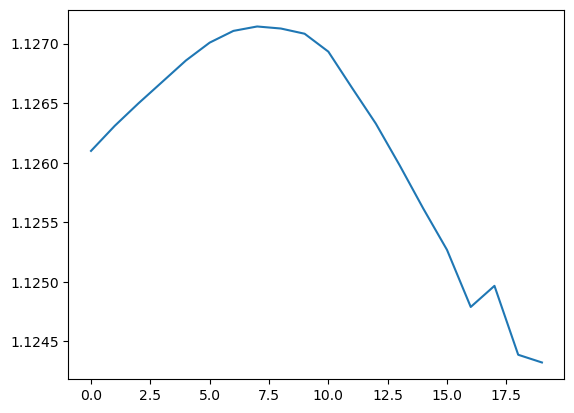

In [253]:
plt.plot(end_points[0:20])

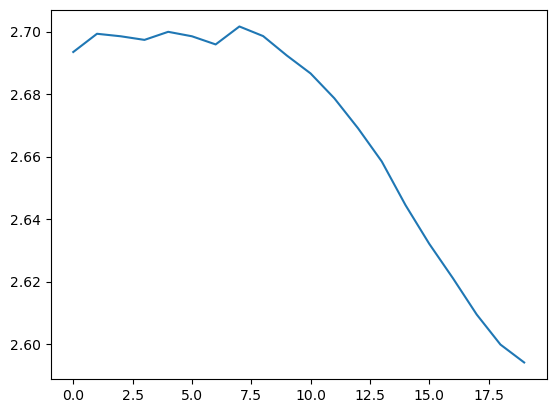

In [95]:
plt.plot(end_points[20:40])

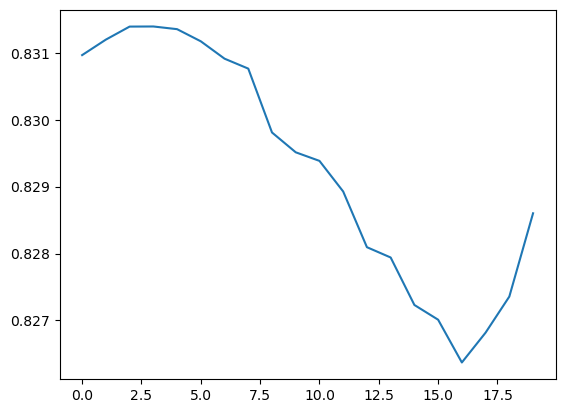

In [97]:
plt.plot(end_points[40:60])

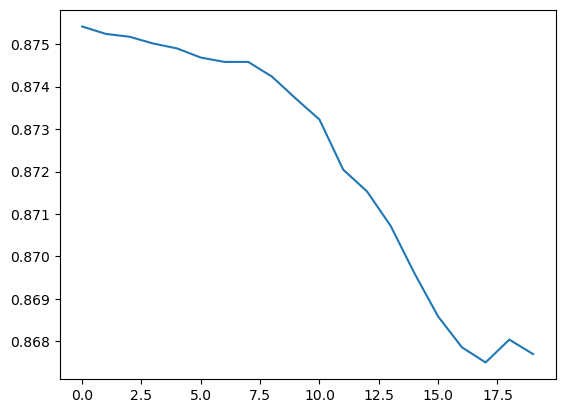

In [89]:
plt.plot(end_points[60:80])

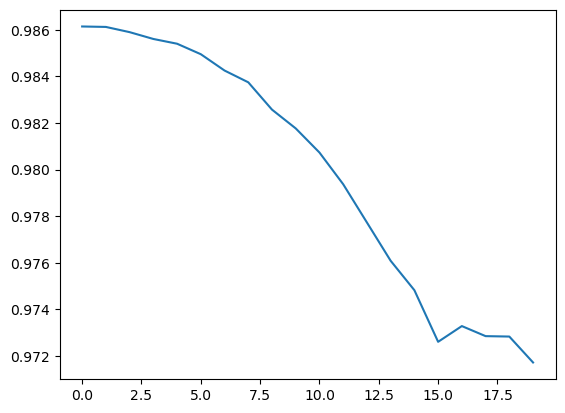

In [91]:
plt.plot(end_points[80:100])

In [73]:
saved_global_kin1=saved_global_kin
saved_global_emakin1=saved_global_emakin
saved_global_loss1=saved_global_loss
saved_global_emaloss1=saved_global_emaloss
saved_global_stdkin1=saved_global_stdkin

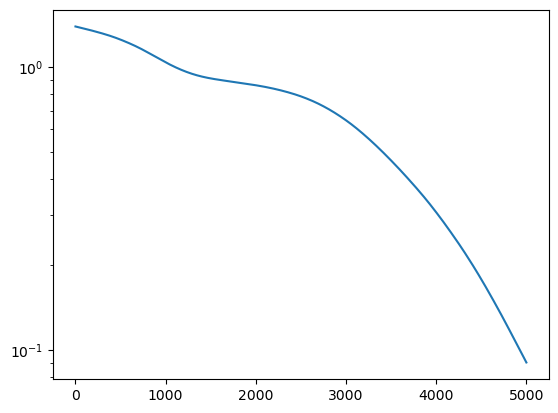

In [183]:
plt.plot(saved_global_loss[0])

plt.yscale("log")

In [75]:
%store saved_global_kin1
%store saved_global_emakin1
%store saved_global_loss1
%store saved_global_emaloss1
%store saved_global_stdkin1

Stored 'saved_global_kin1' (list)
Stored 'saved_global_emakin1' (list)
Stored 'saved_global_loss1' (list)
Stored 'saved_global_emaloss1' (list)
Stored 'saved_global_stdkin1' (list)


In [101]:
%store save_A
%store save_B
%store save_x00

Stored 'save_A' (list)
Stored 'save_B' (list)
Stored 'save_x00' (list)


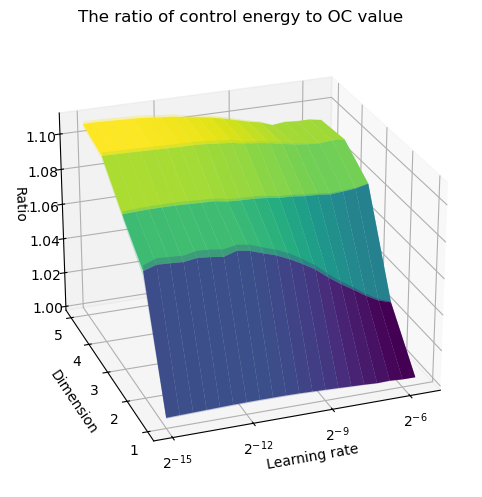

In [251]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FixedLocator
# Example data (replace with your actual data)
end = np.array(end_points)  # Placeholder: 100 points
errs=np.array(std_points)/8
normalize = [1.122, 2.5212, 0.7660, 0.79349, 0.89]  # Placeholder: 5 normalization values

# Reshape end_points into (5, 20) for 5 conditions, each with 20 points
data = end.reshape(5, 20)
errors = errs.reshape(5,20)
# Normalize each row by the corresponding value in normalize
normalize = np.array(normalize)[:, None]  # Shape (5, 1) for broadcasting
normalized_data = data / normalize  # Shape (5, 20)
normalized_erros= errors/normalize
# Create meshgrid for X and Y axes
x = np.arange(5)  # Conditions (e.g., 0, 1, 2, 3, 4 or learning rates)
y = np.arange(20)  # Indices of points (e.g., time steps or epochs)
X, Y = np.meshgrid(x, y, indexing='ij')  # Shape (5, 20)

# Transpose normalized_data to match meshgrid shape (5, 20)
# Z values for the surface
Z = normalized_data

# Upper and lower bounds for shaded error surface
Z_upper = Z + normalized_erros
Z_lower = Z - normalized_erros


# Create 3D surface plot
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(Y,X,  Z, cmap='viridis', edgecolor='none')
surf_upper = ax.plot_surface(Y,X,  Z_upper, cmap='viridis', alpha=0.3, label='Upper Bound')
surf_lower = ax.plot_surface(Y,X,  Z_lower, cmap='viridis', alpha=0.3, label='Lower Bound')
# Customize axes
ax.set_xlabel('Learning rate',labelpad=0,fontsize=10)
ax.set_ylabel('Dimension',labelpad=0,fontsize=10)
ax.set_zlabel('Ratio',labelpad=0,fontsize=10)
ax.set_title('The ratio of control energy to OC value', pad=0)
xticks=np.arange(0, 5)
ax.set_yticks(np.arange(0, 5))
ax.set_yticklabels(['1', '2', '3', '4', '5'])
#yticks = [0,  4,  8,12,16,20]
#yticklabels = [r'$2^{-15}$',  r'$2^{-13}$',   r'$2^{-11}$', r'$2^{-9}$',  r'$2^{-7}$' ,  r'$2^{-5}$']
yticks = [0,  6,  12, 18]
yticklabels = [r'$2^{-15}$',    r'$2^{-12}$', r'$2^{-9}$',  r'$2^{-6}$' ]
zticks = [1.00, 1.02, 1.04, 1.06, 1.08, 1.10]
ztickslabels = ["1.00", "1.02", "1.04", "1.06", "1.08", "1.10"]
ax.set_zticks(zticks)
ax.set_zticklabels(ztickslabels)
ax.set_xticks(yticks)
ax.set_xticklabels(yticklabels)
ax.view_init(elev=25, azim=250)
ax.xaxis.set_major_locator(FixedLocator(yticks))
ax.xaxis.grid(True)
ax.yaxis.set_major_locator(FixedLocator(xticks))
# Optionally, set X-axis to learning rates (uncomment if applicable)
# learning_rates = [2**(-12), 2**(-13), 2**(-14), 2**(-15), 2**(-16)]
# ax.set_xticks(np.arange(5))
# ax.set_xticklabels([f'$2^{{-{12+i}}}$' for i in range(5)])
ax.tick_params(axis='x', pad=0)  # Reduce padding for X-axis ticks
ax.tick_params(axis='y', pad=0)  # Reduce padding for Y-axis ticks
ax.tick_params(axis='z', pad=1)  # Slightly larger for Z-axis due to 3D perspective

# Add colorbar
#fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)


# Adjust layout and save as PDF

plt.savefig('surface_plot.pdf', format='pdf', bbox_inches='tight')
plt.show()
plt.close()

In [115]:
%store end_points

Stored 'end_points' (list)


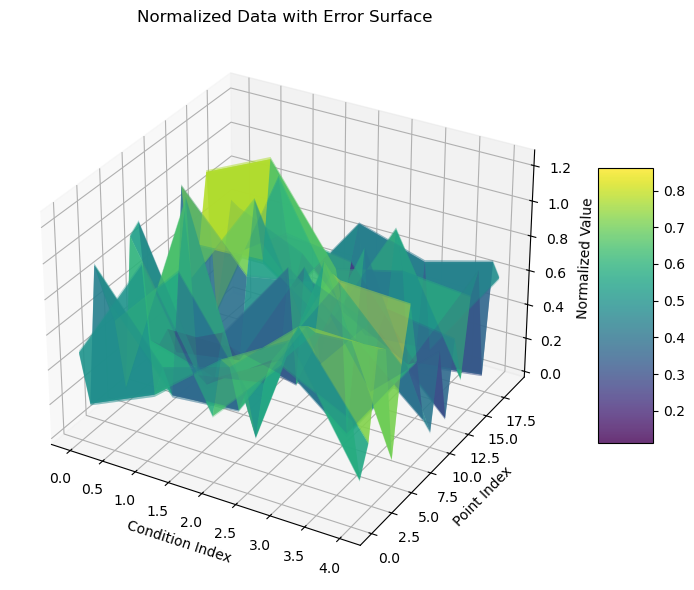

In [151]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example data (replace with your actual data)
end_points = np.random.rand(100)  # Placeholder: 100 points (5 conditions × 20 points)
normalize = [1.0, 0.8, 1.2, 0.9, 1.1]  # Placeholder: 5 normalization values
errors = np.ones([5, 20]) * 0.01  # Placeholder: errors for each point

# Reshape end_points into (5, 20) for 5 conditions, each with 20 points
data = end_points.reshape(5, 20)

# Normalize each row by the corresponding value in normalize
normalize = np.array(normalize)[:, None]  # Shape (5, 1) for broadcasting
normalized_data = data / normalize  # Shape (5, 20)

# Normalize errors similarly (assuming errors are in the same scale as data)
normalized_errors = errors / normalize  # Shape (5, 20)

# Create meshgrid for X and Y axes
x = np.arange(5)  # Conditions (e.g., 0, 1, 2, 3, 4 or learning rates)
y = np.arange(20)  # Indices of points (e.g., time steps or epochs)
X, Y = np.meshgrid(x, y, indexing='ij')  # Shape (5, 20)

# Z values for the surface
Z = normalized_data

# Upper and lower bounds for shaded error surface
Z_upper = Z + normalized_errors
Z_lower = Z - normalized_errors

# Create 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot main surface
surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, label='Normalized Data')

# Option 1: Plot shaded error surfaces (recommended)
surf_upper = ax.plot_surface(X, Y, Z_upper, cmap='viridis', alpha=0.3, label='Upper Bound')
surf_lower = ax.plot_surface(X, Y, Z_lower, cmap='viridis', alpha=0.3, label='Lower Bound')

# Option 2: Plot error bars (uncomment to use instead of shaded surfaces)
# for i in range(5):
#     for j in range(20):
#         ax.plot([X[i, j], X[i, j]], [Y[i, j], Y[i, j]], 
#                 [Z_lower[i, j], Z_upper[i, j]], color='black', linestyle='-', linewidth=0.5)

# Customize axes
ax.set_xlabel('Condition Index')
ax.set_ylabel('Point Index')
ax.set_zlabel('Normalized Value')
ax.set_title('Normalized Data with Error Surface')

# Optionally, set X-axis to learning rates (uncomment if applicable)
# learning_rates = [2**(-12), 2**(-13), 2**(-14), 2**(-15), 2**(-16)]
# ax.set_xticks(np.arange(5))
# ax.set_xticklabels([f'$2^{{-{12+i}}}$' for i in range(5)])

# Add colorbar for main surface
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Adjust layout and save as PDF
plt.tight_layout()
plt.savefig('surface_plot_with_error.pdf', format='pdf', bbox_inches='tight')
plt.show()
plt.close()